# Isochrone Analysis

This notebook processes the 15-minute isochrones produced in `Create Isochrones in Batches`.

## Initialize and Import

In [1]:
# for data analysis
import pandas as pd

# for spatial data analysis
import geopandas as gpd

# for plotting
import matplotlib.pyplot as plt

# for basemaps
import contextily as ctx

# for the geometry???
from shapely import wkt

# for interactive plots
import plotly.express as px


First up, bring in the individual `iso` files, stick them together, and then reformat them as a geodataframe with a Web Mercator Projection.

In [2]:
# bring in iso.csv from each batch
iso1 = pd.read_csv('data/iso1.csv')
iso2 = pd.read_csv('data/iso2.csv')
iso3 = pd.read_csv('data/iso3.csv')
iso4 = pd.read_csv('data/iso4.csv')
iso5 = pd.read_csv('data/iso5.csv')
iso6 = pd.read_csv('data/iso6.csv')

In [3]:
# bind isos into one dataframe
iso = pd.concat([iso1, iso2, iso3, iso4, iso5, iso6])

In [4]:
# define geometry column
iso['geometry'] = iso['geometry'].apply(wkt.loads)

# convert to geodataframe
iso = gpd.GeoDataFrame(iso, geometry = 'geometry').copy()

# set projection
iso = iso.set_crs("EPSG:3857")

# rename columns
iso.columns = ['name', 'something', 'time', 'geometry']

# get desired columns
iso = iso[['name', 'time', 'geometry']].copy()

Now bring in the vaccine distribution locations as a geojson and set the projection to Web Mercator. 

In [5]:
# bring in vaccine locations
vac = gpd.read_file('data/vac.geojson')

In [6]:
# set projection
vac = vac.to_crs("EPSG:3857")

Finally, I'll export the iso as a csv to store for future notebooks.

In [7]:
# export to .csv to store
iso.to_csv('data/iso.csv')

## Map

All of the isochrones are now stored in a single geodataframe. Let's plot those and the location of the vaccine distribution centers. By making all the polygons the same transparent color, a rudimentary heatmap is formed. Darker areas indicate areas with multiple vaccine sites within walking distance.

For our final project, I'd like to create a more sophisticated heat map. Either I'll figure out method involving spatial joins or look further into [this](https://livingwithmachines.ac.uk/heatmap-for-polygons-visualise-overlaps-in-a-large-polygon-dataset/) method, which creates a heatmap based on the alpha (transparency) values of a raster image. 

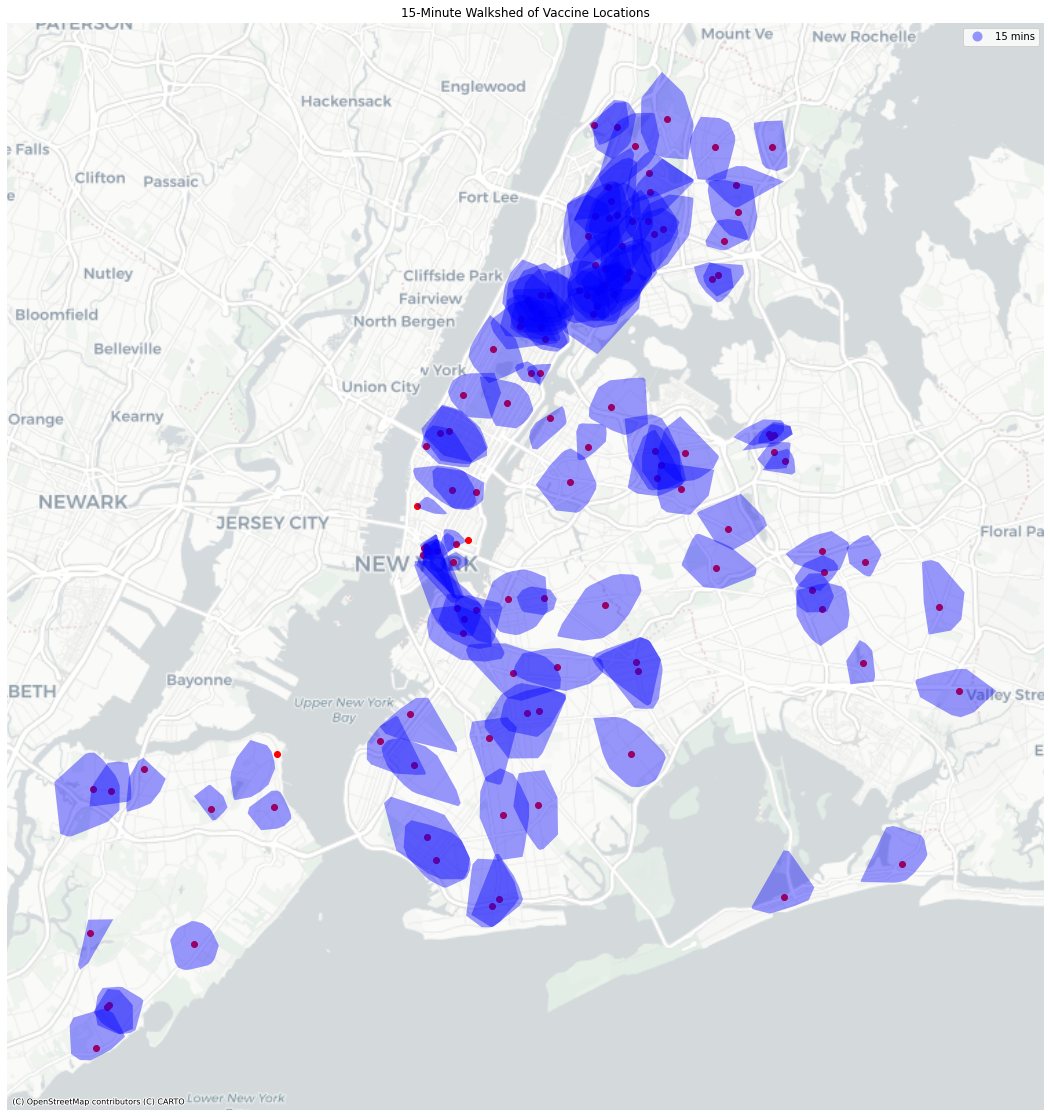

In [8]:
# set up the subplots
fig, ax = plt.subplots(figsize=(20,20))

# add the isochrones
iso.plot(alpha=0.4, 
            ax=ax,  
            column='time',
            cmap='winter', 
            legend=True,
            zorder=20)

# add the distribution location
vac.plot(ax=ax,color='r')


# hide the axis
ax.axis('off')

# give it a title
ax.set_title('15-Minute Walkshed of Vaccine Locations')

# add the basemap
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)


For the initial analysis, we're interested in neighborhoods that have 15-minute walk access to a vaccine distribution center. In order to simplify, I'll dissolve all of the polygons into one single polygon. Note that I've kept 'time' as a dummy variable to do the dissolve, even though all of the values are "15 mins." 

In [9]:
# select columns to keep after dissolve
isod = iso[['time', 'geometry']]

In [10]:
# dissolve the polygons by "time"
isod = isod.dissolve(by = 'time')

Let's see how that looks.

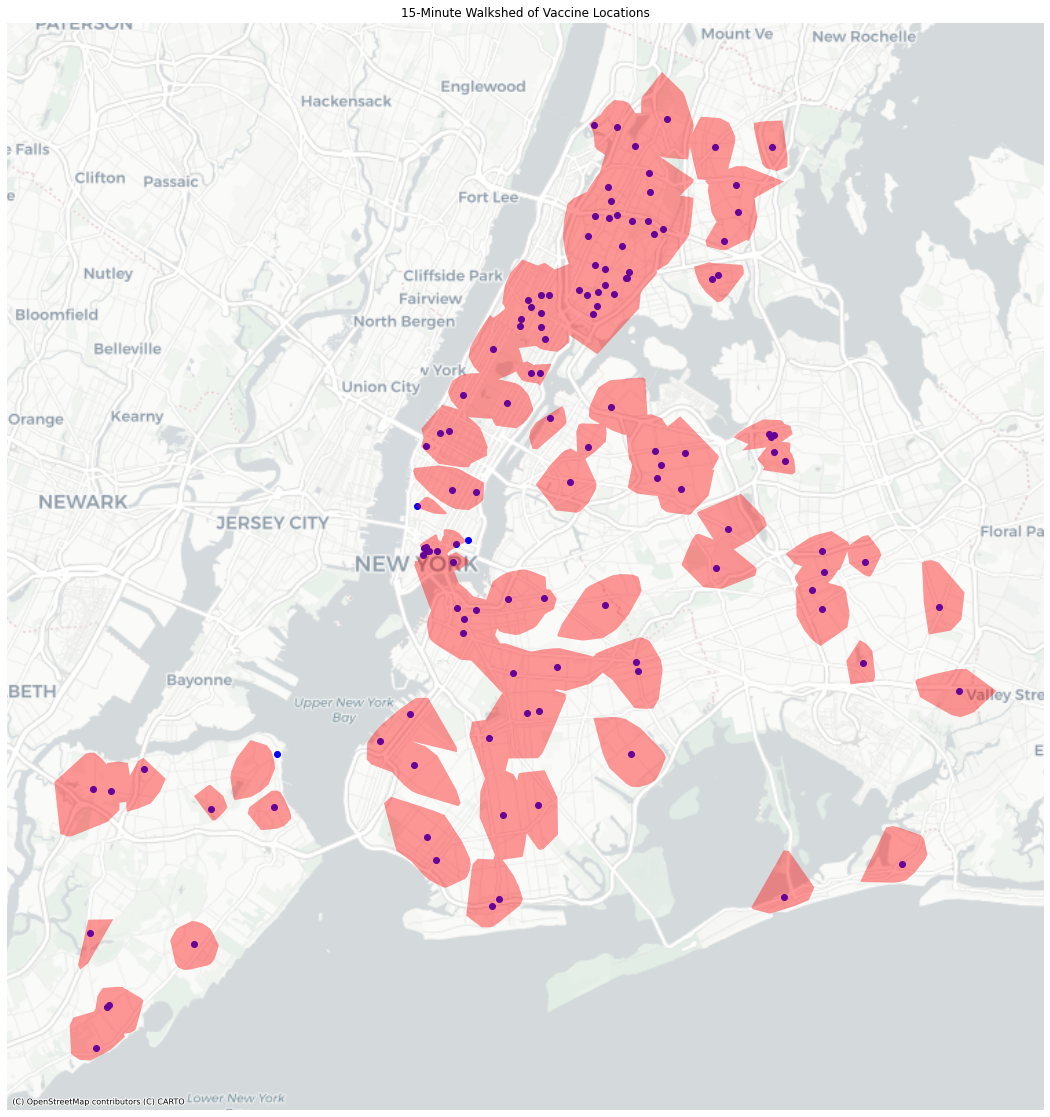

In [11]:
# set up the subplots
fig, ax = plt.subplots(figsize=(20,20))

# add the distribution location
vac.plot(ax=ax,color='b')

# add the isochrones
isod.plot(alpha=0.4, 
            ax=ax,  
            cmap='hsv', 
            legend=True,
            zorder=20)




# hide the axis
ax.axis('off')

# give it a title
ax.set_title('15-Minute Walkshed of Vaccine Locations')

# add the basemap
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

This dataset is now ready for further analysis.